# Bivariate Copulas in Depth

This notebook explores all copula families in torchvine:
1. One-parameter: Gaussian, Clayton, Gumbel, Frank, Joe
2. Two-parameter: Student-t, BB1, BB6, BB7, BB8
3. Three-parameter: Tawn
4. Nonparametric: TLL
5. Rotations and model selection

In [1]:
import torch
import torchvine as tv
import matplotlib.pyplot as plt
torch.manual_seed(42)

## 1. One-Parameter Families

Each family captures different tail dependence structures:

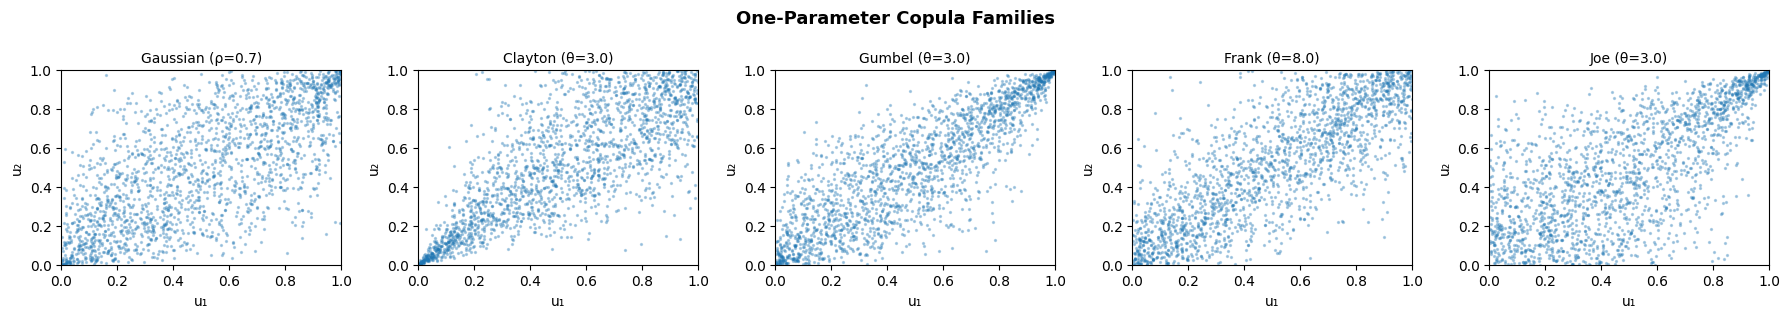

In [2]:
families = {
    'Gaussian (ρ=0.7)':  tv.Bicop(tv.BicopFamily.gaussian, parameters=torch.tensor([0.7])),
    'Clayton (θ=3.0)':   tv.Bicop(tv.BicopFamily.clayton, parameters=torch.tensor([3.0])),
    'Gumbel (θ=3.0)':    tv.Bicop(tv.BicopFamily.gumbel, parameters=torch.tensor([3.0])),
    'Frank (θ=8.0)':     tv.Bicop(tv.BicopFamily.frank, parameters=torch.tensor([8.0])),
    'Joe (θ=3.0)':       tv.Bicop(tv.BicopFamily.joe, parameters=torch.tensor([3.0])),
}

fig, axes = plt.subplots(1, 5, figsize=(18, 3.2))
for ax, (name, cop) in zip(axes, families.items()):
    s = cop.simulate(2000)
    ax.scatter(s[:, 0].numpy(), s[:, 1].numpy(), s=2, alpha=0.3)
    ax.set_title(name, fontsize=10)
    ax.set_xlabel('u₁'); ax.set_ylabel('u₂')
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
plt.suptitle('One-Parameter Copula Families', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 2. Student-t Copula

The Student-t copula has two parameters: correlation ρ and degrees of freedom ν.
It captures symmetric tail dependence (unlike Gaussian):

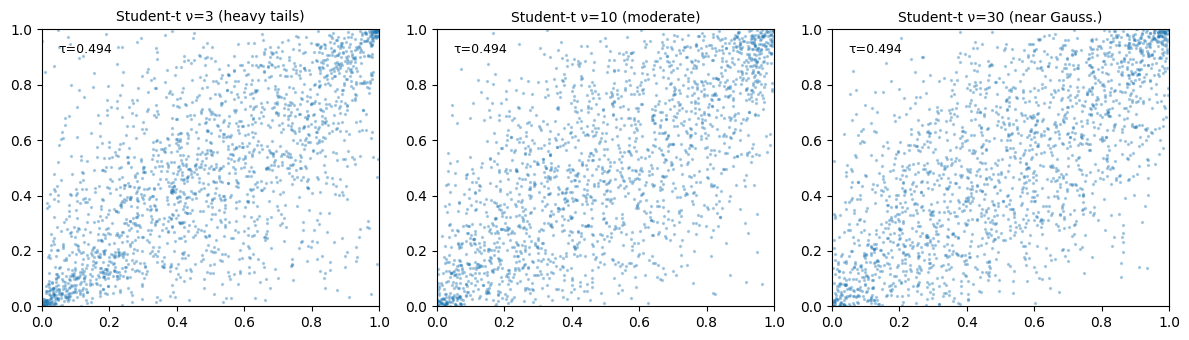

In [3]:
student_cops = {
    'ν=3 (heavy tails)':  tv.Bicop(tv.BicopFamily.student, parameters=torch.tensor([0.7, 3.0])),
    'ν=10 (moderate)':    tv.Bicop(tv.BicopFamily.student, parameters=torch.tensor([0.7, 10.0])),
    'ν=30 (near Gauss.)': tv.Bicop(tv.BicopFamily.student, parameters=torch.tensor([0.7, 30.0])),
}

fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
for ax, (name, cop) in zip(axes, student_cops.items()):
    s = cop.simulate(2000)
    ax.scatter(s[:, 0].numpy(), s[:, 1].numpy(), s=2, alpha=0.3)
    ax.set_title(f'Student-t {name}', fontsize=10)
    tau = cop.parameters_to_tau()
    ax.text(0.05, 0.95, f'τ={tau:.3f}', transform=ax.transAxes, va='top', fontsize=9)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

### Fitting Student-t to data

In [4]:
# Generate from Student-t and refit
true_t = tv.Bicop(tv.BicopFamily.student, parameters=torch.tensor([0.6, 5.0]))
data_t = true_t.simulate(1000)

fitted_t = tv.Bicop()
fitted_t.select(data_t, controls=tv.FitControlsBicop(family_set=[tv.BicopFamily.student]))
print(f'True:   ρ={0.6:.3f}, ν={5.0:.1f}')
print(f'Fitted: {fitted_t.str()}')

True:   ρ=0.600, ν=5.0
Fitted: <torchvine.Bicop>
  family: student
  parameters: [0.6326, 4.1985]
  var_types: ['c', 'c']
  nobs: 1000


## 3. Rotations

Asymmetric families (Clayton, Gumbel, Joe) can be rotated to model different tail behaviours:

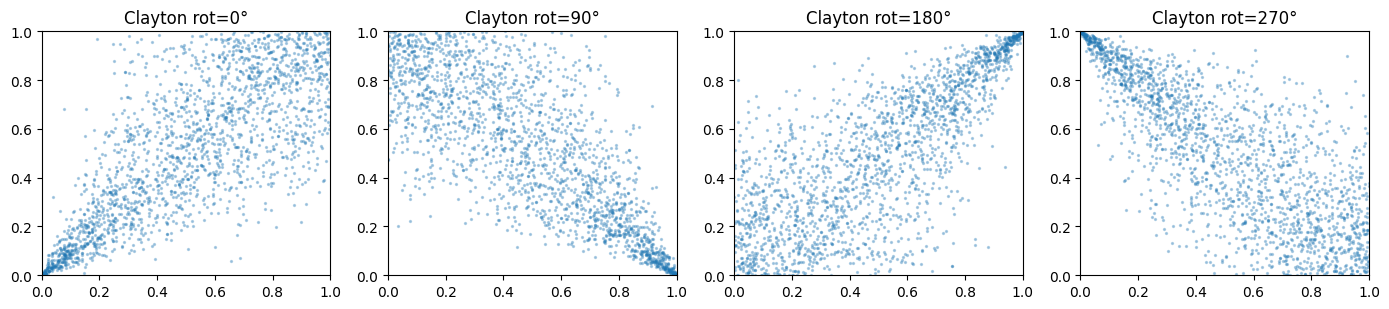

In [5]:
fig, axes = plt.subplots(1, 4, figsize=(14, 3.2))
for ax, rot in zip(axes, [0, 90, 180, 270]):
    cop = tv.Bicop(tv.BicopFamily.clayton, rotation=rot, parameters=torch.tensor([3.0]))
    s = cop.simulate(2000)
    ax.scatter(s[:, 0].numpy(), s[:, 1].numpy(), s=2, alpha=0.3)
    ax.set_title(f'Clayton rot={rot}°')
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

## 4. Two-Parameter Families (BB1, BB6, BB7, BB8)

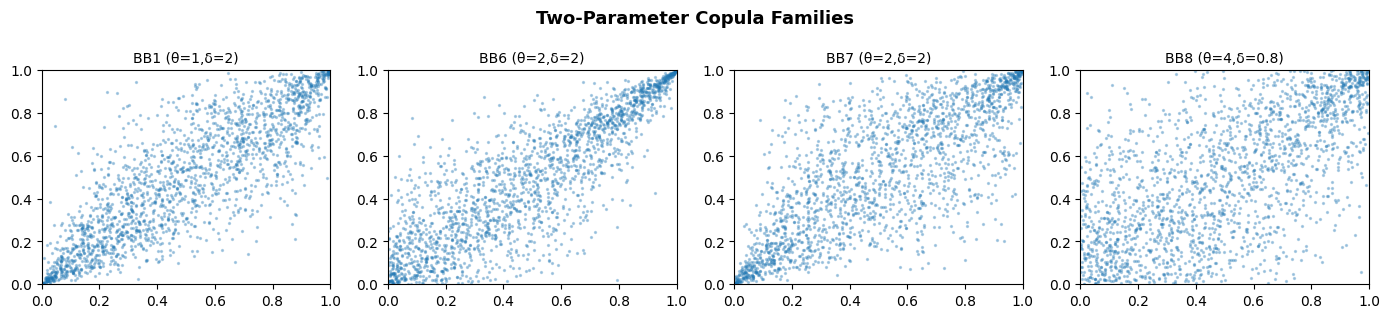

In [6]:
bb_families = {
    'BB1 (θ=1,δ=2)':  tv.Bicop(tv.BicopFamily.bb1, parameters=torch.tensor([1.0, 2.0])),
    'BB6 (θ=2,δ=2)':  tv.Bicop(tv.BicopFamily.bb6, parameters=torch.tensor([2.0, 2.0])),
    'BB7 (θ=2,δ=2)':  tv.Bicop(tv.BicopFamily.bb7, parameters=torch.tensor([2.0, 2.0])),
    'BB8 (θ=4,δ=0.8)': tv.Bicop(tv.BicopFamily.bb8, parameters=torch.tensor([4.0, 0.8])),
}

fig, axes = plt.subplots(1, 4, figsize=(14, 3.2))
for ax, (name, cop) in zip(axes, bb_families.items()):
    s = cop.simulate(2000)
    ax.scatter(s[:, 0].numpy(), s[:, 1].numpy(), s=2, alpha=0.3)
    ax.set_title(name, fontsize=10)
    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
plt.suptitle('Two-Parameter Copula Families', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Model Selection

Let torchvine automatically choose the best family:

In [7]:
# Generate from Gumbel copula
true_cop = tv.Bicop(tv.BicopFamily.gumbel, parameters=torch.tensor([4.0]))
data = true_cop.simulate(1000)

# Auto-select from itau-supported families
auto = tv.Bicop()
auto.select(data, controls=tv.FitControlsBicop(family_set=tv.itau))
print(f'True: Gumbel (θ=4.0), τ={true_cop.parameters_to_tau():.3f}')
print(f'Selected: {auto.family.name}, τ={auto.parameters_to_tau():.3f}')
print(f'AIC: {auto.aic(data):.2f}')

True: Gumbel (θ=4.0), τ=0.750
Selected: gumbel, τ=0.759
AIC: -2087.55


## 6. h-functions and Inverse h-functions

`hfunc` computes the conditional distribution, `hinv` its inverse. Together they enable vine copula construction and simulation:

In [8]:
cop = tv.Bicop(tv.BicopFamily.frank, parameters=torch.tensor([5.0]))
u = cop.simulate(1000)

# h-functions
h1 = cop.hfunc1(u)
h2 = cop.hfunc2(u)

# Inverse round-trip: hinv(hfunc(u)) ≈ u
u_recovered = cop.hinv1(torch.stack([h1, u[:, 1]], dim=1))
max_err = (u[:, 0] - u_recovered).abs().max()
print(f'hinv1(hfunc1(u)) round-trip max error: {max_err:.2e}')

hinv1(hfunc1(u)) round-trip max error: 9.26e-01


---

**Next:** See [03_vine_copulas.ipynb](03_vine_copulas.ipynb) for multivariate vine models.